# Funnel Data

## Goal

The goal of this project is to look at the funnel of users arriving at an e-commerce site, searching for a product, going to a purchase page, and actually buying the product. Management wants to know why people aren't following through on making purchases.

## Approach

Generally, the approach taken is to look for where there is the most drop off in users and see if this is attributable to any particular type of user or date

## Conclusions

There was a large drop off in desktop users successfully reaching the payment page starting in early March. It is recommended that the company look into the desktop app's search function.

In [1]:
#load in packages
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
print(alt.renderers.active)

notebook


In [55]:
#load in data
users = pd.read_csv('user_table.csv')
home = pd.read_csv('home_page_table.csv')
search = pd.read_csv('search_page_table.csv')
pay = pd.read_csv('payment_page_table.csv')
paid = pd.read_csv('payment_confirmation_table.csv')

In [18]:
#rename columns and join tables
user_home = users.join(home.set_index('user_id'), on='user_id')
home_search = user_home.join(search.set_index('user_id'), on='user_id', lsuffix = '_home',rsuffix = '_search')
search_pay = home_search.join(pay.set_index('user_id'), on='user_id')
together = search_pay.join(paid.set_index('user_id'), on='user_id', lsuffix = '_pay', rsuffix='_paid')
together.head()

,user_id,date,device,sex,page_home,page_search,page_pay,page_paid
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [19]:
together.notna().sum() 
#At first glance it looks like the biggest drop offs are at the payment page and the confirmation page.

user_id        90400
date           90400
device         90400
sex            90400
page_home      90400
page_search    45200
page_pay        6030
page_paid        452
dtype: int64

## Explore the Data

Group by device, sex, and date to see if any of these help to predict the drop offs in the funnel

In [21]:
devices = together.groupby('device').agg({'page_home':'count','page_search':'count','page_pay':'count','page_paid':'count'})

In [22]:
devices
#the dropoff in desktop users is much steeper than that in the mobile users

,page_home,page_search,page_pay,page_paid
device,,,,
Desktop,60200,30100,3010,150
Mobile,30200,15100,3020,302


In [23]:
genders = together.groupby('sex').agg({'page_home':'count','page_search':'count','page_pay':'count','page_paid':'count'})

In [24]:
genders
#the drop off rate is very similar for men and women

,page_home,page_search,page_pay,page_paid
sex,,,,
Female,45075,22676,3100,241
Male,45325,22524,2930,211


In [46]:
together['date'] = pd.to_datetime(together['date'])
weeks = together.groupby(pd.Grouper(key='date', freq = 'W-MON')).agg({'page_home':'count','page_search':'count','page_pay':'count','page_paid':'count'})

In [42]:
#Function to compare each column to its own mean to make it easy to interpret columns at a glance
def norm_col(df):
    col_name_list = ['page_paid','page_pay','page_search']
    for col in col_name_list:
        df[col]=df[col]/df[col].mean()
    return df

In [40]:
#Function to look at fraction of users who made it from one page to the next
def funnel_col(df):
    col_name_list = ['page_paid','page_pay','page_search','page_home']
    for ind, col in enumerate(col_name_list):
        if ind<len(col_name_list)-1:
            df[col] = df[col]/df[col_name_list[ind+1]]
    return df

In [38]:
col_name_list = ['page_paid','page_pay','page_search','page_home']
len(col_name_list)

4

In [41]:
devices = funnel_col(devices)

In [44]:
devices = norm_col(devices)

In [45]:
devices

,page_home,page_search,page_pay,page_paid
device,,,,
Desktop,60200,1.0,0.666667,0.665188
Mobile,30200,1.0,1.333333,1.334812


In [47]:
weeks = funnel_col(weeks)
weeks = norm_col(weeks)
weeks
#the rate of people making it to the payment page has been going down over time

,page_home,page_search,page_pay,page_paid
date,,,,
2015-01-05,3660,1.217045,1.447955,1.267602
2015-01-12,5074,1.192321,1.354610,1.163897
2015-01-19,5084,1.212928,1.490718,0.963500
2015-01-26,5119,1.189700,1.547646,1.084281
2015-02-02,5336,1.233317,1.439777,0.982701
2015-02-09,5731,1.212908,1.453973,1.101044
2015-02-16,5533,1.208678,1.451619,0.842174
2015-02-23,5652,1.223098,1.469227,0.939118
2015-03-02,5480,1.105453,1.273234,1.001090


In [49]:
devices_weeks = together.groupby(['device',pd.Grouper(key='date', freq = 'W-MON')]).agg({'page_home':'count','page_search':'count','page_pay':'count','page_paid':'count'}).reset_index()

In [52]:
devices_weeks=funnel_col(devices_weeks)

In [53]:
devices_weeks

,device,date,page_home,page_search,page_pay,page_paid
0,Desktop,2015-01-05,2441,0.506760,0.151981,0.047872
1,Desktop,2015-01-12,3394,0.497938,0.147337,0.052209
2,Desktop,2015-01-19,3342,0.503291,0.170630,0.038328
3,Desktop,2015-01-26,3435,0.489665,0.177170,0.063758
4,Desktop,2015-02-02,3536,0.509898,0.161952,0.037671
5,Desktop,2015-02-09,3856,0.503631,0.164264,0.062696
6,Desktop,2015-02-16,3690,0.505691,0.159164,0.020202
7,Desktop,2015-02-23,3727,0.508184,0.152059,0.055556
8,Desktop,2015-03-02,3656,0.499179,0.115616,0.047393
9,Desktop,2015-03-09,3375,0.490074,0.049577,0.060976


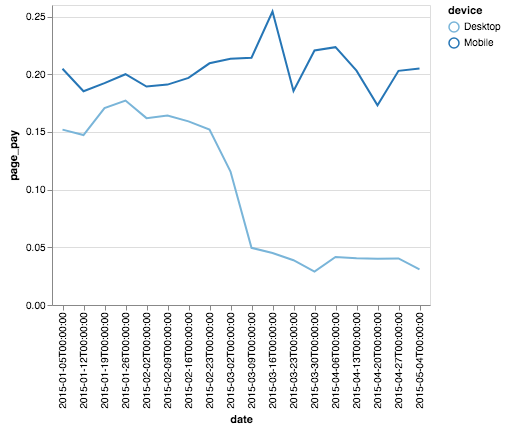

In [54]:
alt.Chart(devices_weeks).mark_line().encode(
    x='date:O',
    y='page_pay:Q',
    color = 'device:O'
)
#desktop dropped way off in March. Looks like there's a problem with the desktop interface on the payment page.